In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/My\ Drive/New\ Dataset /content/Dataset

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model

import random as rn
import numpy as np

Set up tensorflow session.

In [ ]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

Build classification model using VGG16.

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
def build_model():

  # Freeze vgg model
  for layer in vgg_model.layers:
      layer.trainable = False
  vgg_model.trainable = False
  classification_model = keras.layers.Flatten(name="flatten")(vgg_model.output)
  classification_model = keras.layers.Dense(512, activation="relu")(classification_model)
  classification_model = keras.layers.Dropout(0.25)(classification_model)
  classification_model = keras.layers.Dense(3, activation="softmax")(classification_model)

  model = Model(inputs=vgg_model.input, outputs=classification_model)

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-4),
      loss=keras.losses.categorical_crossentropy,
      metrics=['accuracy'])
  
  return model

model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

Load training and validation datasets.

In [ ]:
SEED = 42
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
  rotation_range=45,           # apply rotations to augment data
  width_shift_range=0.2,       # horizontal shift
  height_shift_range=0.2,      # vertical shift
  horizontal_flip=True,        # image flips
  zoom_range=0.2,              # zoom
  brightness_range=[0.8,1.2],   # brightness
  fill_mode='nearest'
)
batchsize = 10
train_generator = train_datagen.flow_from_directory(
  directory = "/content/Dataset/train",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = True,
  class_mode = 'categorical',
  seed=SEED
)

batchsize = 1
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=(1./255))
valid_generator = valid_datagen.flow_from_directory(
  directory = "/content/Dataset/validation",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = False,
  class_mode = 'categorical'
)

Found 380 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


Check accuracy and loss of untrained model.

In [ ]:
loss0, accuracy0 = model.evaluate(valid_generator)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

63/63 [==============================] - 35s 455ms/step - loss: 0.8448 - accuracy: 0.6887
initial loss: 1.34
initial accuracy: 0.33


Apply weights to balance data.

In [ ]:
def get_class_weight():
  bathroom = 133
  bedroom = 134
  kitchen = 113
  total = bathroom + bedroom + kitchen
  class_weight = {0: total / bathroom, 1: total / bedroom, 2: total / kitchen}
  return class_weight

Train the model.

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg_{epoch:03d}.h5', monitor='val_accuracy', verbose=1, save_best_only=False, save_freq='epoch')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

training = model.fit(
  train_generator,
  class_weight=get_class_weight(),
  epochs=30,
  validation_data=valid_generator,
  callbacks=[checkpoint, early_stopping],
  verbose=1,
)

Epoch 1/30
38/38 [==============================] - 14s 353ms/step - loss: 3.5619 - accuracy: 0.4896 - val_loss: 0.5041 - val_accuracy: 0.8095

Epoch 00001: saving model to vgg_001.h5
Epoch 2/30
38/38 [==============================] - 13s 347ms/step - loss: 1.4324 - accuracy: 0.7722 - val_loss: 0.4498 - val_accuracy: 0.8095

Epoch 00002: saving model to vgg_002.h5
Epoch 3/30
38/38 [==============================] - 13s 346ms/step - loss: 1.5119 - accuracy: 0.7876 - val_loss: 0.3507 - val_accuracy: 0.8571

Epoch 00003: saving model to vgg_003.h5
Epoch 4/30
38/38 [==============================] - 13s 347ms/step - loss: 1.2787 - accuracy: 0.8485 - val_loss: 0.4117 - val_accuracy: 0.8254

Epoch 00004: saving model to vgg_004.h5
Epoch 5/30
38/38 [==============================] - 13s 350ms/step - loss: 1.3255 - accuracy: 0.8348 - val_loss: 0.3385 - val_accuracy: 0.8730

Epoch 00005: saving model to vgg_005.h5
Epoch 6/30
38/38 [==============================] - 13s 349ms/step - loss: 1.295

Verify accuracy and loss during training.

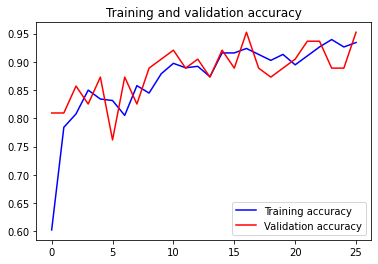

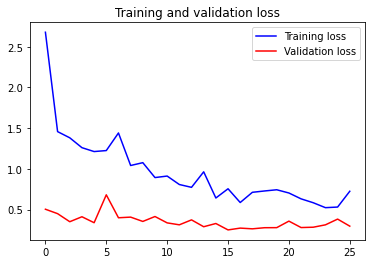

In [ ]:
accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Unfreeze top layers of VGG model and procede with training.

In [ ]:
vgg_model.trainable = True
num = len(vgg_model.layers) - 8
for layer in vgg_model.layers[num:]:
  layer.trainable =  True

model.compile(
  optimizer=keras.optimizers.RMSprop(lr=1e-5),
  loss=keras.losses.categorical_crossentropy,
  metrics=['accuracy'])

training_fine = model.fit(train_generator,
  class_weight=get_class_weight(),
  epochs=60,
  validation_data=valid_generator,
  initial_epoch=training.epoch[-1],
  callbacks=[checkpoint, early_stopping],
  verbose=1,
)

Epoch 26/60
38/38 [==============================] - 14s 352ms/step - loss: 0.4861 - accuracy: 0.9436 - val_loss: 0.2780 - val_accuracy: 0.9524

Epoch 00026: saving model to vgg_026.h5
Epoch 27/60
38/38 [==============================] - 13s 347ms/step - loss: 0.4598 - accuracy: 0.9425 - val_loss: 0.2804 - val_accuracy: 0.9524

Epoch 00027: saving model to vgg_027.h5
Epoch 28/60
38/38 [==============================] - 13s 350ms/step - loss: 0.2897 - accuracy: 0.9648 - val_loss: 0.2717 - val_accuracy: 0.9524

Epoch 00028: saving model to vgg_028.h5
Epoch 29/60
38/38 [==============================] - 13s 346ms/step - loss: 0.5989 - accuracy: 0.9338 - val_loss: 0.2696 - val_accuracy: 0.9365

Epoch 00029: saving model to vgg_029.h5
Epoch 30/60
38/38 [==============================] - 13s 345ms/step - loss: 0.4008 - accuracy: 0.9468 - val_loss: 0.2703 - val_accuracy: 0.8889

Epoch 00030: saving model to vgg_030.h5
Epoch 31/60
38/38 [==============================] - 13s 344ms/step - loss:

Verify accuracy and loss after training the model with unfreezed layers.

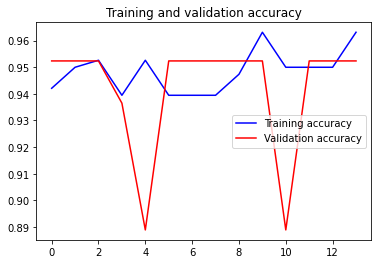

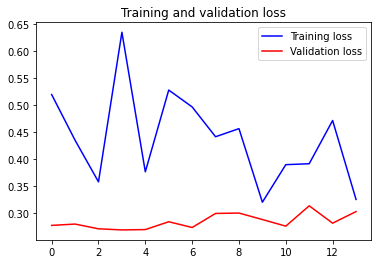

In [ ]:
accuracy = training_fine.history['accuracy']
val_accuracy = training_fine.history['val_accuracy']
loss = training_fine.history['loss']
val_loss = training_fine.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Apply model to test dataset for evaluation.

In [ ]:
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = tsdata.flow_from_directory(
  directory="/content/Dataset/test",
  target_size=(256, 256),
  shuffle=False,
  batch_size=1,
  seed=42
)

model = load_model('vgg_035.h5')

results = model.evaluate(test_generator)
print(results)
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))
print(confusion_matrix(test_generator.classes, predictions))

Found 82 images belonging to 3 classes.
82/82 [==============================] - 2s 20ms/step - loss: 6.0964 - accuracy: 0.9146
[6.096358776092529, 0.9146341681480408]
              precision    recall  f1-score   support

    Bathroom       1.00      0.92      0.96        25
     Bedroom       1.00      0.86      0.93        37
     Kitchen       0.74      1.00      0.85        20

    accuracy                           0.91        82
   macro avg       0.91      0.93      0.91        82
weighted avg       0.94      0.91      0.92        82

[[23  0  2]
 [ 0 32  5]
 [ 0  0 20]]


**Grad-CAM Section**

Load and show an image.

Found 82 images belonging to 3 classes.


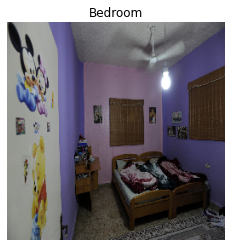

In [57]:
tsdata = ImageDataGenerator(rescale=(1./255))
test_generator = tsdata.flow_from_directory(
  directory="/content/Dataset/test",
  target_size=(256, 256),
  shuffle=True,
  batch_size=1,
  seed=42
)

def get_label_number(label):
  if label[0] == 1:
    return 0
  elif label[1] == 1: 
    return 1
  else:
    return 2

class_dict = test_generator.class_indices
image, label = test_generator.next()
for j in range(0, 1):
  plt.imshow(image[j])
  plt.title(list(class_dict.keys())[list(class_dict.values()).index(get_label_number(label[j]))])
  plt.axis("off")

Verify name of fully connected layers.


In [43]:
model = load_model("vgg_035.h5")
model.summary()

last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "flatten",
    "dense_2",
    "dropout_1",
    "dense_3"
]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

Get gradients and overimpose heatmap on the image.

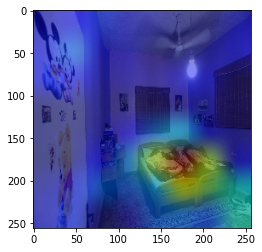

In [58]:
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
classification_net = classifier_input
for layer_name in classifier_layer_names:
  classification_net = model.get_layer(layer_name)(classification_net)
classifier_model = keras.Model(classifier_input, classification_net)

with tf.GradientTape() as tape:
  # Compute activations of the last conv layer and make the tape watch it
  last_conv_layer_output = last_conv_layer_model(image)
  tape.watch(last_conv_layer_output)
  # Compute class predictions
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

# Gradient of the top predicted class
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis=-1)

# Normalize heatmap between 0 and 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

colormap = cm.get_cmap("jet")(heatmap)[:,:,:3]

# Create image with color heatmap
colormap = keras.preprocessing.image.array_to_img(colormap)
colormap = colormap.resize((image[j].shape[1], image[j].shape[0]))
colormap = keras.preprocessing.image.img_to_array(colormap)

# Overlay the heatmap on original image
overlaid_img = image[j]*0.5 + colormap*0.5/255
overlaid_img = keras.preprocessing.image.array_to_img(overlaid_img)

plt.imshow(overlaid_img)
